<a href="https://colab.research.google.com/github/KushalGajjar1/MNIST-Classifier/blob/main/MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

labels = data[:,0]
data   = data[:,1:]

dataNorm = data / np.max(data)

dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

In [ ]:
dataNorm.shape[0]

(20000, 1, 28, 28)

In [ ]:
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
train_loader.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

In [ ]:
def MNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
      self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)

      expectSize = np.floor((5+2*0-1)/1) + 1
      expectSize = 20 * int(expectSize**2)

      self.fc1 = nn.Linear(expectSize, 50)
      self.out = nn.Linear(50, 10)

    def forward(self, x):

      x = F.relu(F.max_pool2d(self.conv1(x), 2))
      x = F.relu(F.max_pool2d(self.conv2(x), 2))

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1, int(nUnits))

      x = F.relu(self.fc1(x))
      x = self.out(x)

      return x

  net = mnistNet()
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

  return net, lossfun, optimizer

In [ ]:
net, lossfun, optimizer = MNISTNet()

In [ ]:
X, y = next(iter(train_loader))

In [ ]:
X, y

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [ ]:
def trainModel():

  numepochs = 10
  net, lossfun, optimizer = MNISTNet()

  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  count = 0

  for epochi in range(numepochs):
    net.train()
    batchAcc = []
    batchLoss = []

    for X, y in train_loader:


      yHat = net(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      matches = torch.argmax(yHat, axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append(accuracyPct)

    trainAcc.append(np.mean(batchAcc))
    losses[epochi] = np.mean(batchLoss)

    net.eval()
    X, y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)

    testAcc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))

  return trainAcc, testAcc, losses, net

In [ ]:
trainAcc, testAcc, losses, net = trainModel()

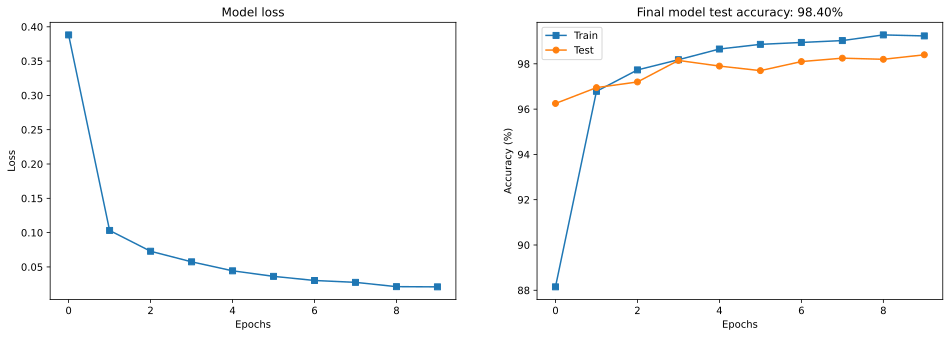

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
X, y = next(iter(test_loader))

In [ ]:
X, y
X.shape

torch.Size([2000, 1, 28, 28])

In [ ]:
yHat = net(X)
res = torch.argmax(yHat, axis=1)

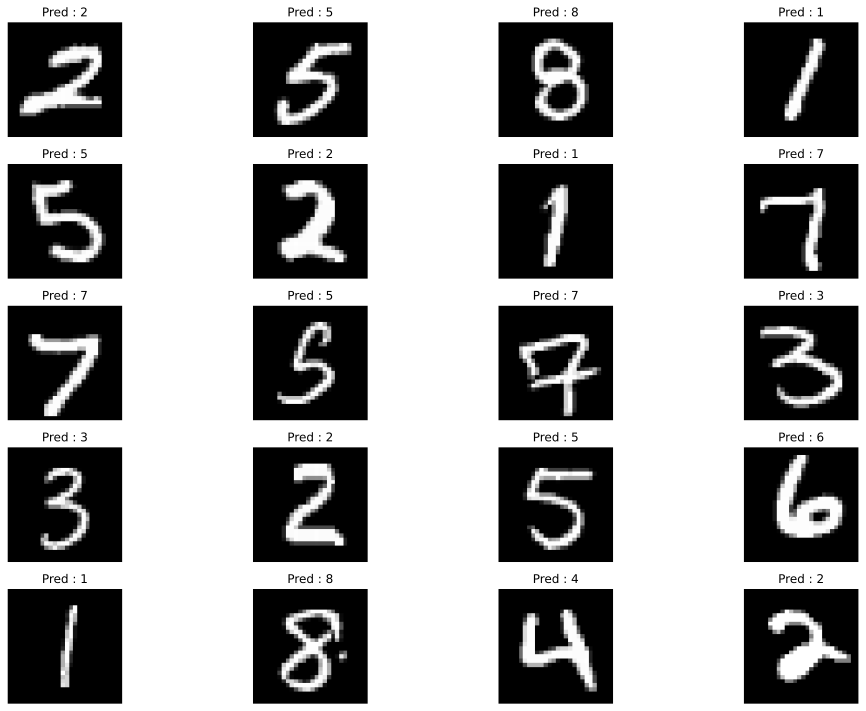

In [ ]:
net.eval()


fig,axs = plt.subplots(5,4,figsize=(15,10))
for i,ax in enumerate(axs.flatten()):

    ax.imshow(X[i,:,].detach().view(28,28),cmap='gray')
    ax.set_title(f"Pred : {res[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()